# Project Benson

## Exploring... and Cleaning

In [18]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
import seaborn as sns
from numpy import linalg

import math
import patsy

from statsmodels.formula.api import ols

%matplotlib inline

In [19]:
!python -V

Python 3.6.3 :: Anaconda custom (64-bit)


In [20]:
print("Pandas version:",pd.__version__)
print("Numpy version:",np.__version__)

Pandas version: 0.20.3
Numpy version: 1.13.3


### Pick a week and play...

In [21]:
!pwd

/home/joseph/ds/Projects/Project_Benson/Exploration


## Data input

I start with the data off the MTA site.  I want a DateTime column immediately.  I already did this
for this first file, so I'm going to unpickle that one instead.

In [22]:
#df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_170415.txt',
df = pd.read_csv('../Data/turnstile_170415.txt',
                       parse_dates = [['DATE','TIME']]
                      )


In [23]:
df.rename(columns={df.columns.values[-1]:'EXITS'}, inplace=True)

In [24]:
#df = pd.read_pickle('../Data/turnstile_170415.pkl', compression='gzip')

In [25]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201197 entries, 0 to 201196
Data columns (total 10 columns):
DATE_TIME    201197 non-null datetime64[ns]
C/A          201197 non-null object
UNIT         201197 non-null object
SCP          201197 non-null object
STATION      201197 non-null object
LINENAME     201197 non-null object
DIVISION     201197 non-null object
DESC         201197 non-null object
ENTRIES      201197 non-null int64
EXITS        201197 non-null int64
dtypes: datetime64[ns](1), int64(2), object(7)
memory usage: 15.4+ MB


Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

The UNIT-SCP-STATION tuple seems appropriate for our index.  We use that and get ready to work with DateTime.

In [26]:
df.set_index(['UNIT','SCP','STATION','DATE_TIME'], inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 201197 entries, (R051, 02-00-00, 59 ST, 2017-04-08 00:00:00) to (R469, 00-05-01, RIT-ROOSEVELT, 2017-04-14 21:00:00)
Data columns (total 6 columns):
C/A         201197 non-null object
LINENAME    201197 non-null object
DIVISION    201197 non-null object
DESC        201197 non-null object
ENTRIES     201197 non-null int64
EXITS       201197 non-null int64
dtypes: int64(2), object(4)
memory usage: 10.9+ MB


Here we resample to standardize and smooth the data.

Using a 1 hour time period permits us the ability to do analysis at a more granular level... but at a bit of a cost of error since although all the turnstiles are out of sync, they do seem all to be at a 4 hour polling.

In [28]:
def resampler(x):    
    return x.set_index('DATE_TIME').resample('1H').mean()


In [29]:
hourly = (df.reset_index(level=3)
 .groupby(level=[0,1,2])
 .apply(resampler)
 .interpolate()
 .diff(1)
)

In [30]:
hourly.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 773104 entries, (R001, 00-00-00, WHITEHALL S-FRY, 2017-04-08 01:00:00) to (R572, 01-03-04, 96 ST-2 AVE, 2017-04-14 21:00:00)
Data columns (total 2 columns):
ENTRIES    773103 non-null float64
EXITS      773103 non-null float64
dtypes: float64(2)
memory usage: 17.7+ MB


In [31]:
hourly.head()

ENTRIES  EXITS
UNIT SCP      STATION         DATE_TIME                          
R001 00-00-00 WHITEHALL S-FRY 2017-04-08 01:00:00      NaN    NaN
                              2017-04-08 02:00:00     12.5   6.25
                              2017-04-08 03:00:00     12.5   6.25
                              2017-04-08 04:00:00     12.5   6.25
                              2017-04-08 05:00:00     12.5   6.25

What we now have is standardized hourly data.  But...

In [32]:
np.sum(hourly.ENTRIES < 0)

7790

In [33]:
np.sum(hourly.ENTRIES > 10000000)

440

In [34]:
np.sum(hourly.ENTRIES < -10000000)

432

What's going on here?  I've verified some of the negative values are legitimate.  Some of the turnstiles appear to be turning backwards.  The solution to that issue is straightforward - just take the absolute value after the diff.  We are interested in traffic.  Direction doesn't matter.

But the other case may be bona fide examples of the turnstile counter rolling over.  Seems roughly an equal number of cases of rolling over in reverse or forward.

In [35]:
hourly.query('abs(ENTRIES) > 500000')

ENTRIES       EXITS
UNIT SCP      STATION         DATE_TIME                                    
R001 00-00-02 WHITEHALL S-FRY 2017-04-08 01:00:00 -1.030830e+06   -640479.0
     00-00-05 WHITEHALL S-FRY 2017-04-08 01:00:00  5.014880e+05    904263.0
     00-00-06 WHITEHALL S-FRY 2017-04-08 01:00:00 -9.178960e+05   -824878.0
     00-00-07 WHITEHALL S-FRY 2017-04-08 01:00:00  1.705650e+06    941931.0
     01-00-00 WHITEHALL S-FRY 2017-04-08 01:00:00 -1.281457e+06    335250.0
     01-00-02 WHITEHALL S-FRY 2017-04-08 01:00:00  2.672996e+06     73454.0
     01-00-03 WHITEHALL S-FRY 2017-04-08 01:00:00  1.308419e+08  49430221.0
     01-06-00 WHITEHALL S-FRY 2017-04-08 01:00:00 -1.694704e+07 -50132358.0
     01-06-01 WHITEHALL S-FRY 2017-04-08 01:00:00 -1.163621e+08   2744963.0
     01-06-02 WHITEHALL S-FRY 2017-04-08 01:00:00 -1.208927e+06  -3016698.0
     02-00-00 SOUTH FERRY     2017-04-08 01:00:00  2.322069e+06   4355318.0
     02-00-01 SOUTH FERRY     2017-04-08 01:00:00 -2.352074e+06  -4350671.0
     02-00-02 SOUTH FERRY     2017-04-08 01:00:00  1.041275e+07   7912813.0
     02-00-03 SOUTH FERRY     2017-04-08 01:00:00 -1.008760e+07  -7796993.0
     02-00-04 SOUTH FERRY     2017-04-08 01:00:00  1.859099e+06   1557391.0
     02-00-07 SOUTH FERRY     2017-04-08 01:00:00  1.103398e+06   -160282.0
     02-06-00 SOUTH FERRY     2017-04-08 01:00:00 -3.538870e+06   -719340.0
     02-07-00 SOUTH FERRY     2017-04-08 01:00:00  1.442537e+06   4616338.0
     02-07-01 SOUTH FERRY     2017-04-08 01:00:00  4.098382e+06    409229.0
     02-07-02 SOUTH FERRY     2017-04-08 01:00:00 -1.834530e+06   1262791.0
     02-07-03 SOUTH FERRY     2017-04-08 01:00:00 -3.005644e+06  -5587672.0
R003 00-00-01 CYPRESS HILLS   2017-04-08 00:00:00  1.417896e+06    395123.0
     00-00-02 CYPRESS HILLS   2017-04-08 00:00:00  2.586273e+06   1936132.0
R004 00-00-00 75 ST-ELDERTS   2017-04-08 00:00:00 -4.086671e+06  -2539932.0
     00-00-01 75 ST-ELDERTS   2017-04-08 00:00:00  3.652757e+06   3134975.0
     00-00-02 75 ST-ELDERTS   2017-04-08 00:00:00 -3.339221e+06  -2830093.0
     00-00-04 75 ST-ELDERTS   2017-04-08 00:00:00  4.603257e+06   2214582.0
R005 00-00-00 85 ST-FOREST PK 2017-04-08 00:00:00  1.681870e+06   2867442.0
     00-00-01 85 ST-FOREST PK 2017-04-08 00:00:00 -2.480187e+06  -4066268.0
     00-00-02 85 ST-FOREST PK 2017-04-08 00:00:00 -4.542028e+06  -2773119.0
...                                                         ...         ...
R549 02-00-00 NEWARK C        2017-04-08 03:00:00 -6.407270e+05    -39249.0
R550 00-00-02 CITY / BUS      2017-04-08 00:00:00  1.479122e+06    678825.0
     00-00-03 CITY / BUS      2017-04-08 00:00:00  9.913000e+05    372580.0
     00-00-04 CITY / BUS      2017-04-08 01:00:00 -2.945830e+06  -1386955.0
     00-00-05 CITY / BUS      2017-04-08 01:00:00  5.378240e+05    328584.0
     00-00-06 CITY / BUS      2017-04-08 01:00:00  2.059757e+06   2487487.0
     00-00-07 CITY / BUS      2017-04-08 02:00:00 -2.565479e+06  -2706062.0
R551 00-00-05 GROVE STREET    2017-04-08 01:00:00  1.126252e+06   1528815.0
     00-00-06 GROVE STREET    2017-04-08 01:00:00 -1.016894e+06  -1436673.0
     00-01-05 GROVE STREET    2017-04-08 04:00:00  5.185080e+05    370138.0
     00-04-00 GROVE STREET    2017-04-08 00:00:00 -5.958200e+05   -501064.0
     00-04-01 GROVE STREET    2017-04-08 03:00:00  7.695110e+05    611509.0
     00-04-02 GROVE STREET    2017-04-08 03:00:00 -7.019310e+05   -597690.0
R552 00-00-02 JOURNAL SQUARE  2017-04-08 02:00:00  1.298906e+06    321909.0
     00-00-03 JOURNAL SQUARE  2017-04-08 03:00:00 -1.112894e+06   -270274.0
     00-00-05 JOURNAL SQUARE  2017-04-08 00:00:00  6.074450e+05    129796.0
     00-00-07 JOURNAL SQUARE  2017-04-08 00:00:00  2.862428e+06    959310.0
     00-00-08 JOURNAL SQUARE  2017-04-08 01:00:00 -2.130904e+06   -309072.0
     00-00-09 JOURNAL SQUARE  2017-04-08 04:00:00 -1.198486e+06   -665975.0
R570 00-05-00 72 ST-2 AVE     2017-04-08 01:00:00  1.170529e+08    -62974.0
     00-05-01 72 ST-2 AVE   

Nope.  If a turnstile counter is rolling over we wouldn't expect it to affect both directions.  One of those rows above might be 

In [36]:
df.loc[('R570','00-05-01','72 ST-2 AVE')]

/home/joseph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


,C/A,LINENAME,DIVISION,DESC,ENTRIES,EXITS
DATE_TIME,,,,,,
2017-04-08 01:00:00,N700,Q,IND,REGULAR,2,117
2017-04-08 05:00:00,N700,Q,IND,REGULAR,2,117
2017-04-08 09:00:00,N700,Q,IND,REGULAR,2,117
2017-04-08 13:00:00,N700,Q,IND,REGULAR,2,117
2017-04-08 17:00:00,N700,Q,IND,REGULAR,2,117
2017-04-08 21:00:00,N700,Q,IND,REGULAR,2,118
2017-04-09 01:00:00,N700,Q,IND,REGULAR,2,118
2017-04-09 09:00:00,N700,Q,IND,REGULAR,2,118
2017-04-09 13:00:00,N700,Q,IND,REGULAR,2,118


No... this is something in the processing.  Let's go slowly...  I'll comment out portions of the assignment to hourly and see how it develops.

First, with just the resample...

In [37]:
hourly = (df.reset_index(level=3)
 .groupby(level=[0,1,2])
 .apply(resampler)
 #.interpolate()
 #.diff(1)
)
hourly.loc[('R570','00-05-01','72 ST-2 AVE')]

,ENTRIES,EXITS
DATE_TIME,,
2017-04-08 01:00:00,2.0,117.0
2017-04-08 02:00:00,NaN,NaN
2017-04-08 03:00:00,NaN,NaN
2017-04-08 04:00:00,NaN,NaN
2017-04-08 05:00:00,2.0,117.0
2017-04-08 06:00:00,NaN,NaN
2017-04-08 07:00:00,NaN,NaN
2017-04-08 08:00:00,NaN,NaN
2017-04-08 09:00:00,2.0,117.0


Now, adding in the interpolate...

In [38]:
hourly = (df.reset_index(level=3)
 .groupby(level=[0,1,2])
 .apply(resampler)
 .interpolate()
 #.diff(1)
)
hourly.loc[('R570','00-05-01','72 ST-2 AVE')]

,ENTRIES,EXITS
DATE_TIME,,
2017-04-08 01:00:00,2.0,117.00
2017-04-08 02:00:00,2.0,117.00
2017-04-08 03:00:00,2.0,117.00
2017-04-08 04:00:00,2.0,117.00
2017-04-08 05:00:00,2.0,117.00
2017-04-08 06:00:00,2.0,117.00
2017-04-08 07:00:00,2.0,117.00
2017-04-08 08:00:00,2.0,117.00
2017-04-08 09:00:00,2.0,117.00


And the diff...

In [39]:
hourly = (df.reset_index(level=3)
 .groupby(level=[0,1,2])
 .apply(resampler)
 .interpolate()
 .diff(1)
)
hourly.loc[('R570','00-05-01','72 ST-2 AVE')]

,ENTRIES,EXITS
DATE_TIME,,
2017-04-08 01:00:00,-117440796.0,117.00
2017-04-08 02:00:00,0.0,0.00
2017-04-08 03:00:00,0.0,0.00
2017-04-08 04:00:00,0.0,0.00
2017-04-08 05:00:00,0.0,0.00
2017-04-08 06:00:00,0.0,0.00
2017-04-08 07:00:00,0.0,0.00
2017-04-08 08:00:00,0.0,0.00
2017-04-08 09:00:00,0.0,0.00


The diff?  What in the world?!?

In [40]:
buggy = df.loc[('R570','00-05-01','72 ST-2 AVE')].copy()

/home/joseph/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


In [41]:
buggy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2017-04-08 01:00:00 to 2017-04-14 21:00:00
Data columns (total 6 columns):
C/A         41 non-null object
LINENAME    41 non-null object
DIVISION    41 non-null object
DESC        41 non-null object
ENTRIES     41 non-null int64
EXITS       41 non-null int64
dtypes: int64(2), object(4)
memory usage: 2.2+ KB


In [42]:
buggy.resample('1H').mean().interpolate().diff(1)

,ENTRIES,EXITS
DATE_TIME,,
2017-04-08 01:00:00,NaN,NaN
2017-04-08 02:00:00,0.0,0.00
2017-04-08 03:00:00,0.0,0.00
2017-04-08 04:00:00,0.0,0.00
2017-04-08 05:00:00,0.0,0.00
2017-04-08 06:00:00,0.0,0.00
2017-04-08 07:00:00,0.0,0.00
2017-04-08 08:00:00,0.0,0.00
2017-04-08 09:00:00,0.0,0.00


OK.  What's going there?!?  Oh.  The cusps of the groupby.  I need to do the interpolate and diff in the apply.

In [43]:
def resampler(x):    
    return x.set_index('DATE_TIME').resample('1H').mean().interpolate().diff()


In [44]:
hourly = (df.reset_index(level=3)
 .groupby(level=[0,1,2])
 .apply(resampler)
)

In [45]:
hourly.loc[('R570','00-05-01','72 ST-2 AVE')]

,ENTRIES,EXITS
DATE_TIME,,
2017-04-08 01:00:00,NaN,NaN
2017-04-08 02:00:00,0.0,0.00
2017-04-08 03:00:00,0.0,0.00
2017-04-08 04:00:00,0.0,0.00
2017-04-08 05:00:00,0.0,0.00
2017-04-08 06:00:00,0.0,0.00
2017-04-08 07:00:00,0.0,0.00
2017-04-08 08:00:00,0.0,0.00
2017-04-08 09:00:00,0.0,0.00


In [51]:
threshold = 1000
hourly.query('abs(EXITS) > %d or abs(ENTRIES) > %d' % (threshold, threshold)).count()

ENTRIES    77
EXITS      77
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f6fa1f6d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4f6e5d6e48>]], dtype=object)

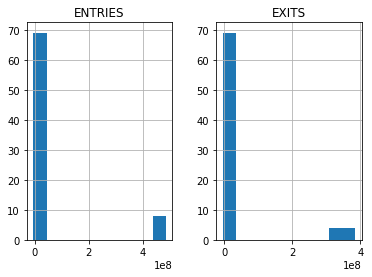

In [52]:
hourly.query('abs(EXITS) > %d or abs(ENTRIES) > %d' % (threshold, threshold)).hist()

**Fixed!**

Let's explore another...

In [ ]:
df.loc[('R570','01-00-03','72 ST-2 AVE')]

So... it's not rollovers.  It's plain ole' resets.  Sheesh.

OK.  It seems clear enough what to do... just set things to zero if outside some range.

Let's test cleanup a bit before we move on to aggregation.

In [ ]:
hourly.fillna(0,inplace=True)

In [ ]:
hourly.loc[('R570','00-05-01','72 ST-2 AVE')].iloc[0]

OK.  That took care of the NaNs created by diff.

Next up, the outliers...

Eeek.  The "EXITS" column name is really messed up!  Lots of extra spaces.

In [ ]:
np.sum(hourly.loc[('R570','01-00-03','72 ST-2 AVE')].iloc[:,-2] < -10000)

In [ ]:
cleanitup = lambda x: abs(x) if abs(x) < 1000 else 0
hourly["ENTRIES"] = hourly["ENTRIES"].map(cleanitup)
hourly["EXITS"] = hourly["EXITS"].map(cleanitup)

In [ ]:
np.sum(hourly.loc[('R570','01-00-03','72 ST-2 AVE')].iloc[:,-2] < -10000)

In [ ]:
np.sum(hourly.iloc[:,-1] < 0)

In [ ]:
df.to_pickle('../Data/turnstile_170415.pkl', compression='gzip')

In [ ]:
hourly.to_pickle('../Data/turnstile_170415_hourly.pkl', compression='gzip')